In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import sys
import json
import wave
import time
import pyaudio
import librosa
import pathlib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Audio
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalMaxPooling2D
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, f1_score, recall_score
from sklearn.model_selection import train_test_split


In [5]:
SEED = 42
BATCH_SIZE = 32
SAMPLE_RATE = 16000
VALIDATION_SPLIT = 0.2

In [6]:
def load_data(json_path):
    with open(json_path, "r") as fp:
        data = json.load(fp)
    return data

train_data = load_data('train_mfccs.json')
test_data = load_data('test_mfccs.json')


In [18]:
# Convert lists to numpy arrays
X_train = np.array(train_data["mfcc"])
y_train = np.array(train_data["labels"])
X_test = np.array(test_data["mfcc"])
y_test = np.array(test_data["labels"])

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [8]:
def model(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(16, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu', padding='same'),
        layers.GlobalMaxPooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(6, activation='softmax')
    ])

    return model

In [9]:
# Input shape
input_shape = (X_train.shape[1], X_train.shape[2], 1)

# Build model
model = model(input_shape)

# Compile model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=32, epochs=50)

Epoch 1/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 0.4530 - loss: 1.4116 - val_accuracy: 0.6134 - val_loss: 1.0203
Epoch 2/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.6188 - loss: 1.0159 - val_accuracy: 0.6513 - val_loss: 0.9179
Epoch 3/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.6647 - loss: 0.9034 - val_accuracy: 0.6805 - val_loss: 0.8404
Epoch 4/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 23s 14ms/step - accuracy: 0.7028 - loss: 0.8026 - val_accuracy: 0.7010 - val_loss: 0.7932
Epoch 5/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 27s 17ms/step - accuracy: 0.7125 - loss: 0.7704 - val_accuracy: 0.7208 - val_loss: 0.7435
Epoch 6/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 26s 16ms/step - accuracy: 0.7334 - loss: 0.7148 - val_accuracy: 0.7277 - val_loss: 0.7157
Epoch 7/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.7453 - loss: 0.6815 - val_accuracy: 0.7282 - val_loss: 0.7393
Epoch 8/50
1637/1637 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - accuracy: 0.7509 -

In [10]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc:.2f}')

164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6392 - loss: 2.1471
Test Accuracy: 0.61


In [11]:
model.save("mfcc_classification_model.h5")

In [12]:
def predict(file_path, model):
    # Load the audio file
    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

    # Extract MFCCs
    mfcc = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T

    # Ensure the correct shape
    mfcc = np.expand_dims(mfcc, axis=-1)
    mfcc = np.expand_dims(mfcc, axis=0)

    # Make prediction
    prediction = model.predict(mfcc)
    predicted_index = np.argmax(prediction, axis=1)
    return predicted_index

# Load the model
model = tf.keras.models.load_model('audio_classification_model.h5')

# Predict
train_data_dir = pathlib.Path('Dataset/Train')

emabega_file_path = os.path.join(train_data_dir, 'emabega', 'emabega_001.wav')
ddyo_file_path = os.path.join(train_data_dir, 'ddyo', 'ddyo_001.wav')

file_path = emabega_file_path
predicted_class = predict(file_path, model)
print(f'Predicted Class: {predicted_class}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Predicted Class: [0]


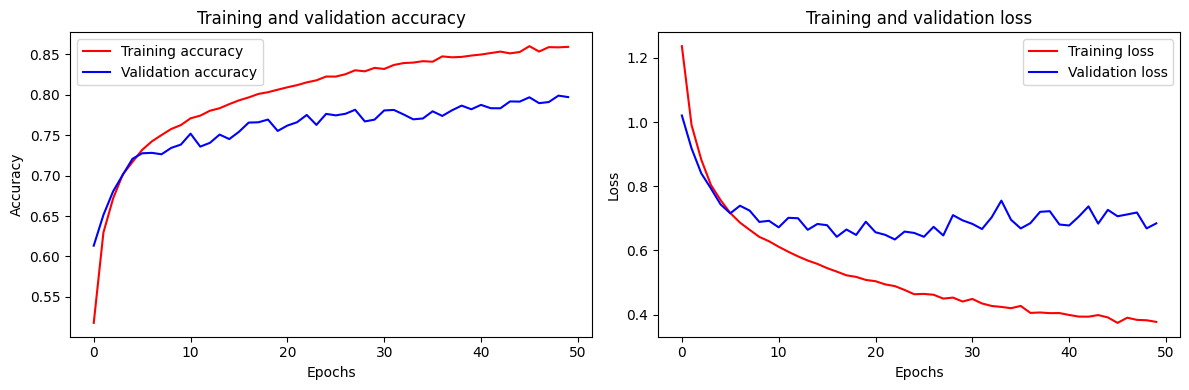

In [13]:

# Function to plot the training history
def plot_training_history(history):
    try:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

        epochs = range(len(acc))

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, acc, 'r', label='Training accuracy')
        plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
        plt.title('Training and validation accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(epochs, loss, 'r', label='Training loss')
        plt.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"An error occurred during plotting the training history: {str(e)}")
        
plot_training_history(history)


In [19]:
# Assuming you have the test data prepared as X_test and y_test
# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Calculate accuracy, precision, and F1 score
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

# Print classification report
class_report = classification_report(y_test, y_pred_classes)
print("Classification Report:\n", class_report)



ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, classification_report


# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)



# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
